In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys
# Importamos nuestras propias funciones
sys.path.append('drive/MyDrive/TFG/src/')

In [ ]:
# from google.colab import files
# files.view('drive/MyDrive/TFG/evaluation.py')

In [ ]:
from numpy import array
import keras
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from data_preparation import train_test_split, scale
from supervised_learning import to_supervised, prior_inverse, invert_scale
from evaluation import measure_rmse, summarize_scores
from data_visualization import boxplot_errors, plot_loss, plot_metrics, plot_pred_vs_real, residuals_dist, residuals_vs_pred

# fit a model
def model_fit(train_x, train_y, test_x, test_y, config):
  # unpack config
  n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, dropout = config
  n_input = n_seq * n_steps

  # Prepare data
  n_features = train_x.shape[2]
  train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, n_features))

  early_stopping = EarlyStopping(patience=5, monitor='loss')
  # define model
  model = keras.Sequential()
  model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
                                   activation='relu', input_shape=(None,n_steps,n_features))))
  model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
                                   activation='relu')))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(Dropout(dropout))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1))

  model.compile(optimizer='adam', loss='mse', metrics=['mae'])

  test_x = test_x.reshape((test_x.shape[0], n_seq, n_steps, n_features))
  # fit
  history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0, callbacks=[early_stopping], validation_data=(test_x, test_y))
  return model, history

# forecast with a pre-fit model
def model_predict(model, history, config):
  # unpack config
  n_seq, n_steps, _, _, _, _, _, _ = config
  n_input = n_seq * n_steps
  # prepare data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  x_input = data[-n_input:]
  x_input = x_input.reshape((1, n_seq, n_steps, x_input.shape[1]))
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, start_test, cfg):
  # split dataset
  train, test = train_test_split(data, start_test)
  # prepare data
  train = train.to_numpy()
  test = test.to_numpy()

  # Escalamos entre 0 y 1
  scaler, train_scaled, test_scaled = scale(train, test, 0, 1)

  n_seq, n_steps, _, _, _, _, _, _ = cfg
  n_input = n_seq * n_steps
  # Dividimos en arrays las valores de entrenamiento y test
  train_x, train_y = to_supervised(train_scaled, n_input)
  test_x, test_y = to_supervised(test_scaled, n_input)
  # fit model
  model, history = model_fit(train_x, train_y, test_x, test_y, cfg)
  # seed history with training dataset
  history_train = [x for x in train_x]
  # step over each time-step in the test set
  predictions = list()
  for i in range(len(test_x)):
    # fit model and make forecast for history
    yhat = model_predict(model, history_train, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history_train.append(test_x[i])

  # Obtenemos los valores en la escala inicial
  power_pred, power_real = invert_scale(scaler, test_x, test_y, predictions)

  # estimate prediction error
  rmse = measure_rmse(power_real, power_pred)
  mae =  mean_absolute_error(power_real, power_pred)
  r2 = r2_score(power_real, power_pred)

  return rmse, mae, r2, history, power_pred, power_real

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=1):
  # convert config to a key
  key = str(config)
  # fit and evaluate the model n times
  inicio = time.time()
  scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
  fin = time.time()
  # Calcular la duración en segundos
  duracion_segundos = fin - inicio

  # Convertir la duración a minutos y segundos
  duracion_minutos, duracion_segundos = divmod(duracion_segundos, 60)
  print(key, "Tiempo transcurrido:", int(duracion_minutos), "minutos y", int(duracion_segundos), "segundos")
  return (key, scores)

# grid search configs
def grid_search(data, cfg_list, n_test):
  # evaluate configs
  scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
  return scores

### Energía fotovoltaica

In [ ]:
import pandas as pd
import time
# Datos totales de energía fotovoltaica
df = pd.read_csv('drive/MyDrive/TFG/data/PV_data.csv', index_col='Time')

# Datos primer año
divide = '2020-01-01'
first_year = df.loc[:divide]

# Configuraciones a testear
# n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, dropout
configs =  [[2, 12, 16, 2, 50, 15, 150, 0.3], [2, 12, 32, 2, 30,30, 150, 0.2]]

# Fecha inicial del test
start_test = '2019-09-31'
scores_1 = grid_search(first_year, configs, start_test)

[2, 12, 16, 2, 50, 15, 150, 0.3] Tiempo transcurrido: 2 minutos y 44 segundos
[2, 12, 32, 2, 30, 30, 150, 0.2] Tiempo transcurrido: 2 minutos y 35 segundos


In [ ]:
# Datos segundo año
# divide = '2020-01-01'
second_year = df.loc[divide:]

# Configuraciones a testear
# n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, dropout
# configs =  [[2, 12,  16, 2, 50, 15, 150, 0.3], [2, 12, 32, 2, 30,30, 150, 0.2]]

# Fecha inicial del test
start_test = '2020-09-31'
scores_2 = grid_search(second_year, configs, start_test)

[2, 12, 16, 2, 50, 15, 150, 0.3] Tiempo transcurrido: 2 minutos y 27 segundos
[2, 12, 32, 2, 30, 30, 150, 0.2] Tiempo transcurrido: 2 minutos y 36 segundos


Config [2, 12, 16, 2, 50, 15, 150, 0.3]
                 RMSE       MAE        R2
Iteración 1  7.164867  4.017036  0.718628
Iteración 2  8.981273  5.359874  0.553341
cnn-lstm: 8.073 RMSE (+/- 0.908)
cnn-lstm: 4.688 MAE (+/- 0.671)
cnn-lstm: 0.636 R2 (+/- 0.083)


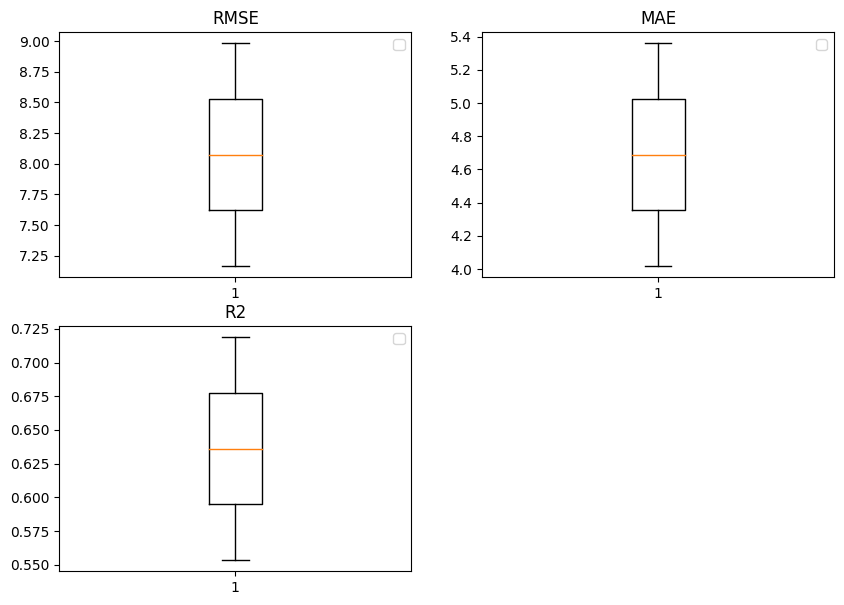

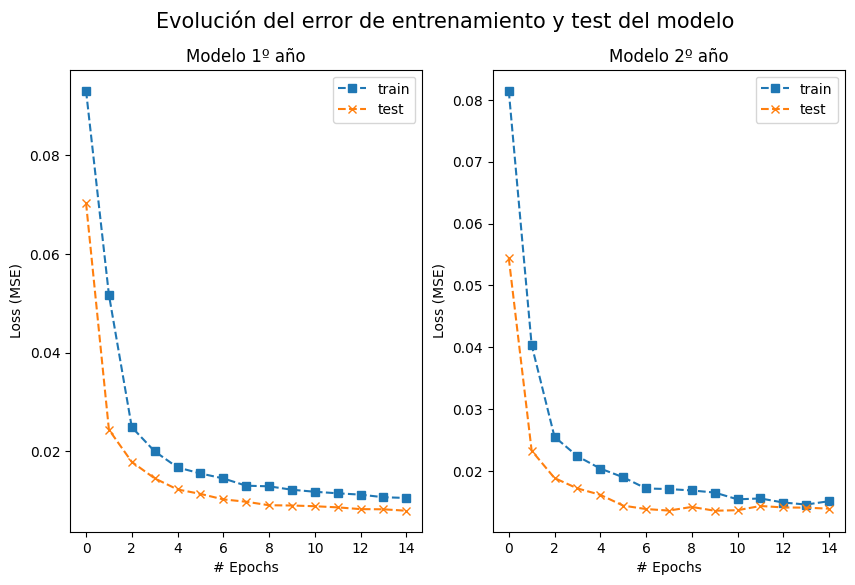

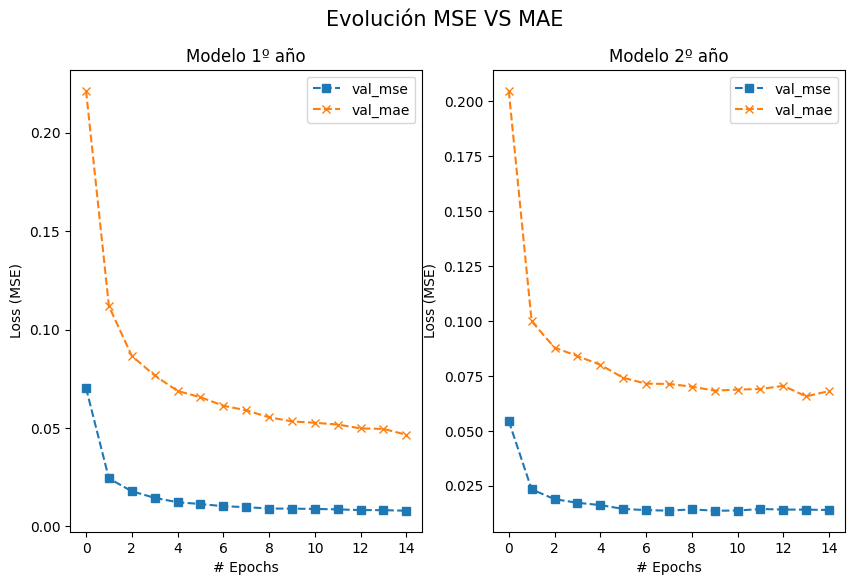

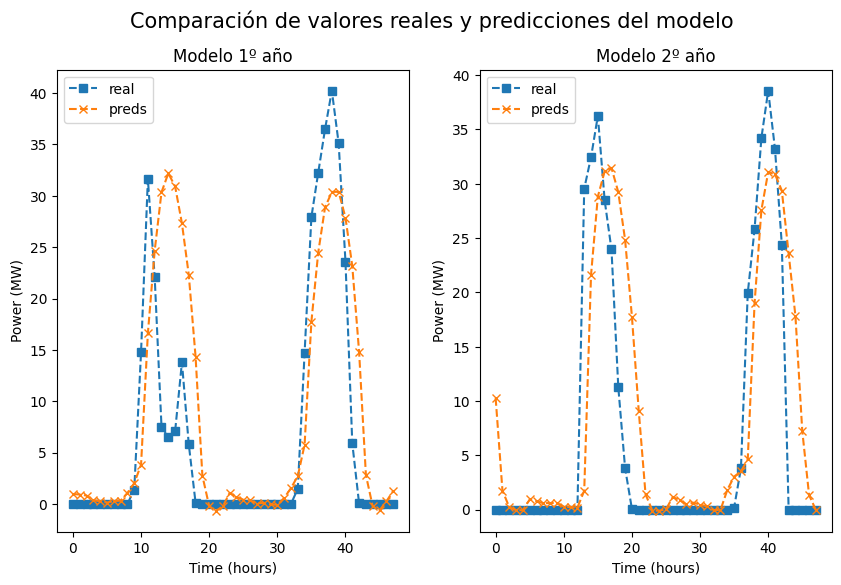

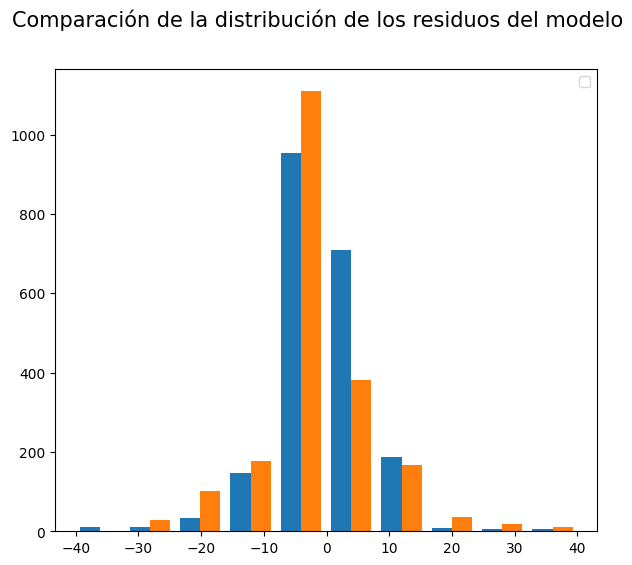

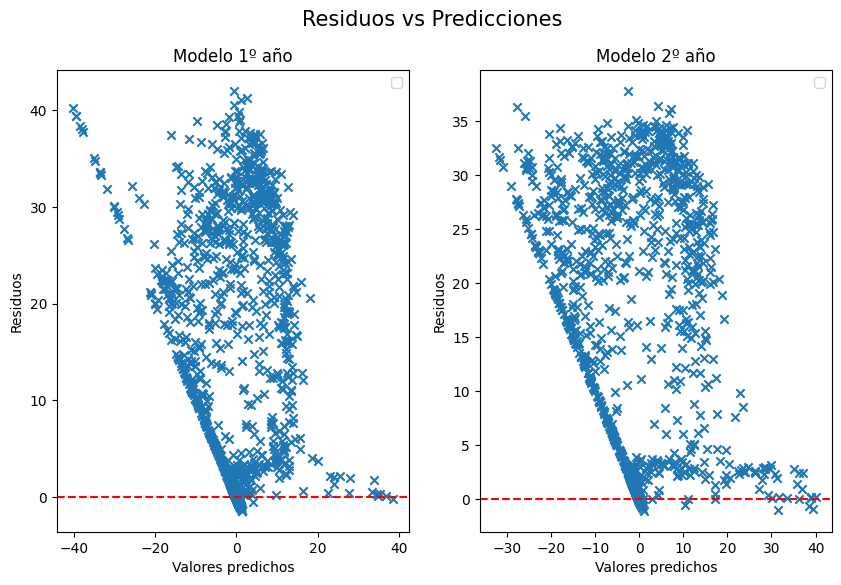

Config [2, 12, 32, 2, 30, 30, 150, 0.2]
                 RMSE       MAE        R2
Iteración 1  6.846620  3.650531  0.743069
Iteración 2  8.726359  4.872000  0.578336
cnn-lstm: 7.786 RMSE (+/- 0.940)
cnn-lstm: 4.261 MAE (+/- 0.611)
cnn-lstm: 0.661 R2 (+/- 0.082)


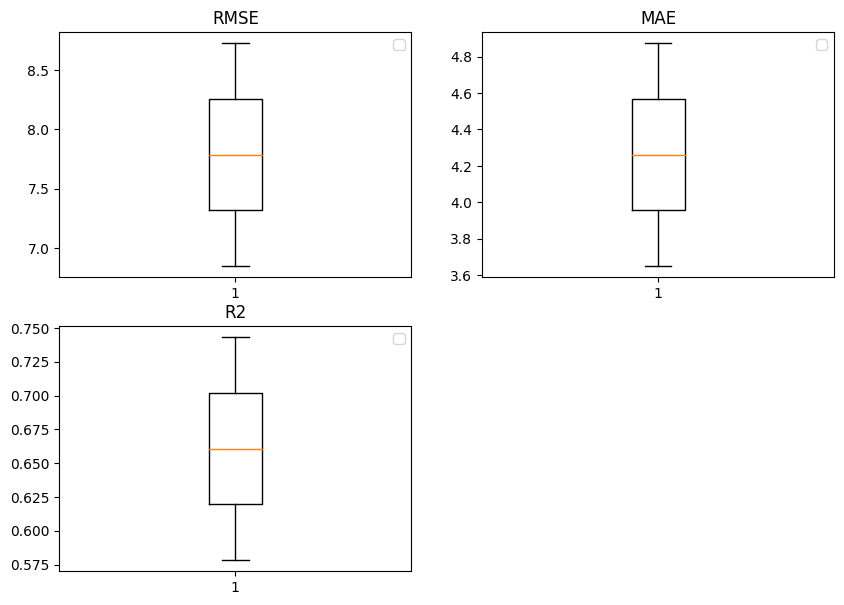

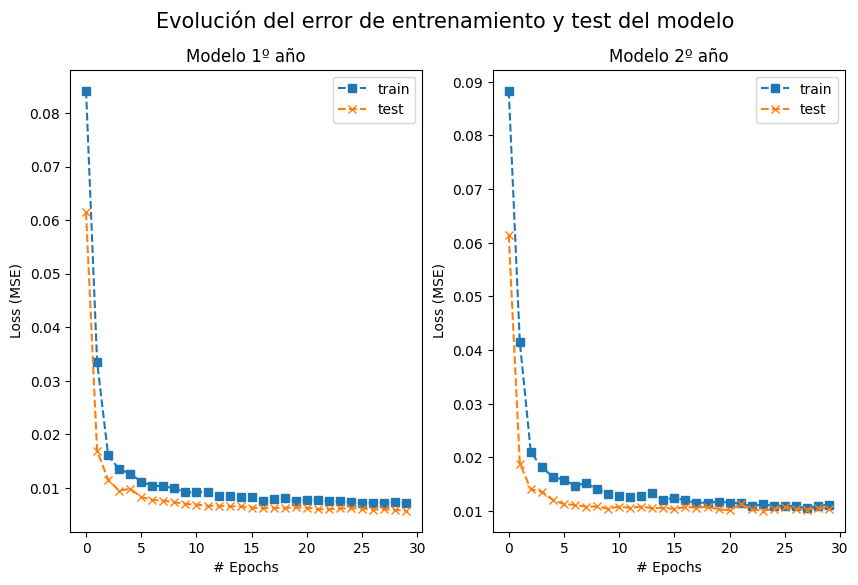

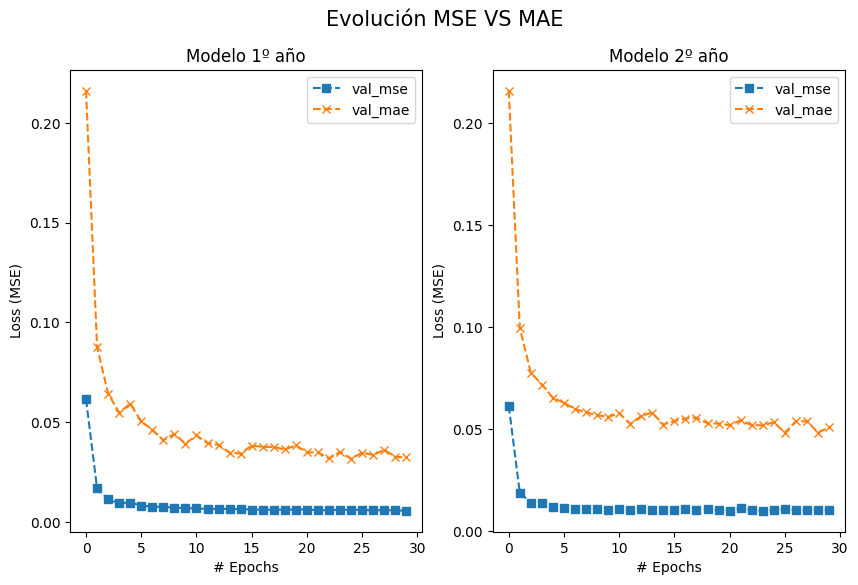

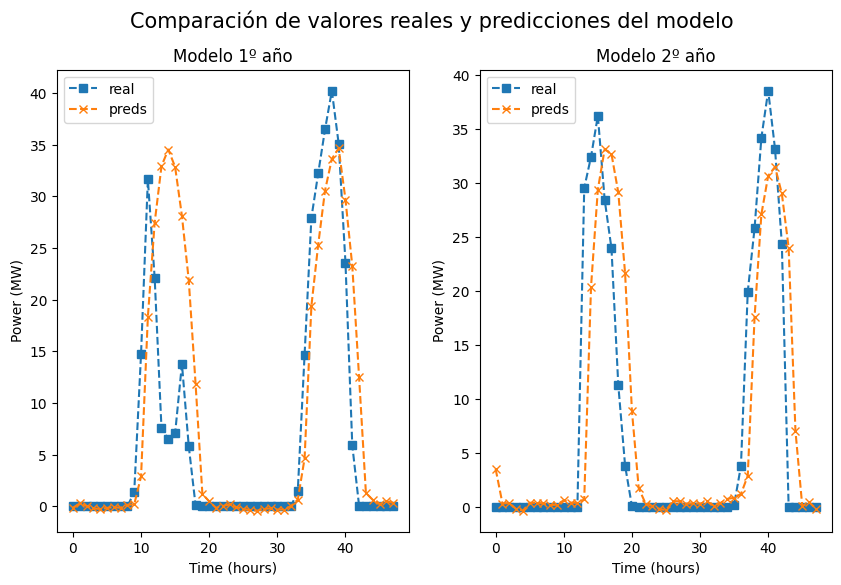

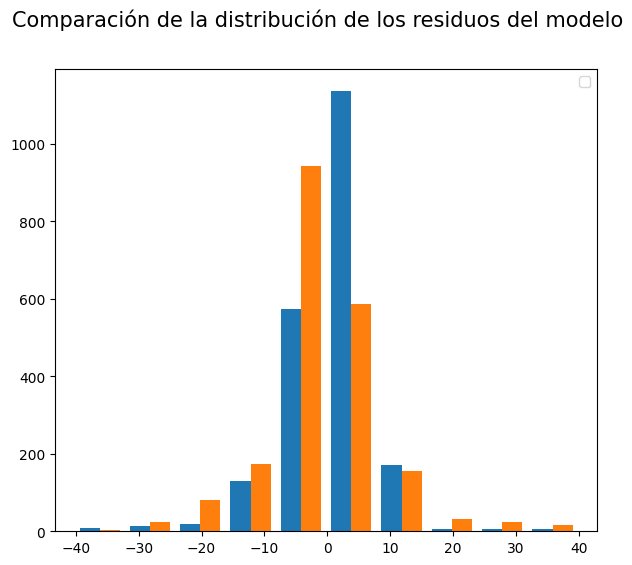

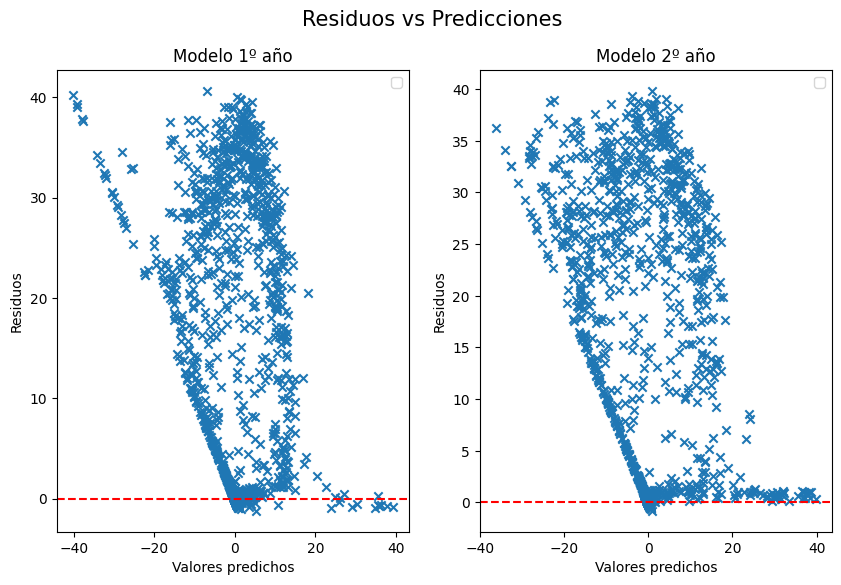

In [ ]:
scores = {config_1: (results_1, results_2) for (config_1, results_1), (config_2, results_2) in zip(scores_1, scores_2) if config_1 == config_2}
summarize_scores('cnn-lstm', scores)

### Energía eólica

In [ ]:
df = pd.read_csv('drive/MyDrive/TFG/data/EO_data.csv', index_col='Time')

# Datos primer año
# divide = '2020-01-01'
first_year = df.loc[:divide]

# Configuraciones a testear
# n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, dropout
configs =  [[7, 24, 16, 2, 50, 15, 150, 0.3], [7, 24, 32, 2, 30,30, 150, 0.2]]

# Fecha inicial del test
start_test = '2019-09-31'
scores_1 = grid_search(first_year, configs, start_test)

[7, 24, 16, 2, 50, 15, 150, 0.3] Tiempo transcurrido: 3 minutos y 3 segundos
[7, 24, 32, 2, 30, 30, 150, 0.2] Tiempo transcurrido: 3 minutos y 10 segundos


In [ ]:
# df = pd.read_csv('drive/MyDrive/TFG/data/EO_data.csv', index_col='Time')

# Datos segundo año
# divide = '2020-01-01'
second_year = df.loc[divide:]

# Configuraciones a testear
# n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, dropout
# configs =  [[7, 24,  16, 2, 50, 15, 150, 0.3], [7, 24, 32, 2, 30,30, 150, 0.2]]

start_test = '2020-09-31'
scores_2 = grid_search(second_year, configs, start_test)
# summarize_scores('cnn-lstm Encoder-Decoder', scores_2)

[7, 24, 16, 2, 50, 15, 150, 0.3] Tiempo transcurrido: 2 minutos y 42 segundos
[7, 24, 32, 2, 30, 30, 150, 0.2] Tiempo transcurrido: 2 minutos y 52 segundos


Config [7, 24, 16, 2, 50, 15, 150, 0.3]
                  RMSE       MAE        R2
Iteración 1  14.036090  9.240688  0.702349
Iteración 2  13.844074  8.923818  0.687698
cnn-lstm: 13.940 RMSE (+/- 0.096)
cnn-lstm: 9.082 MAE (+/- 0.158)
cnn-lstm: 0.695 R2 (+/- 0.007)


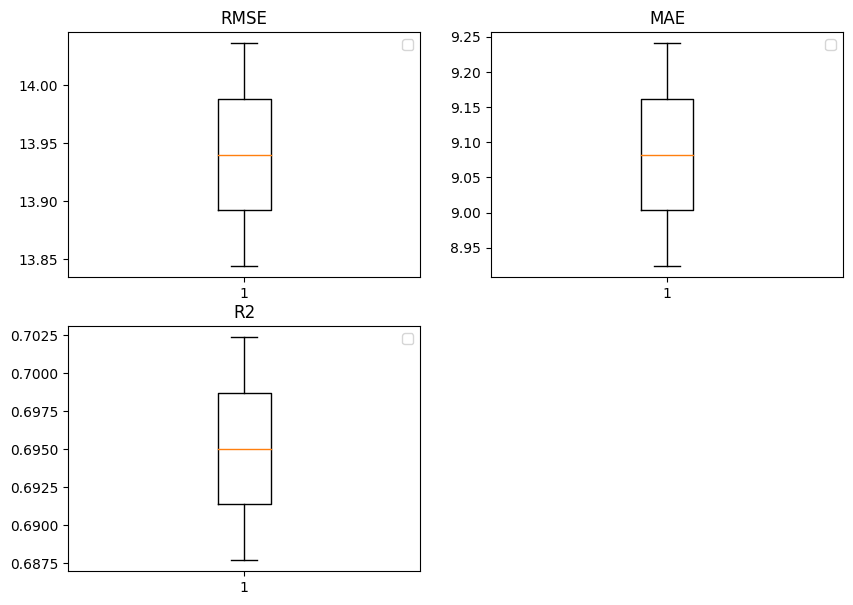

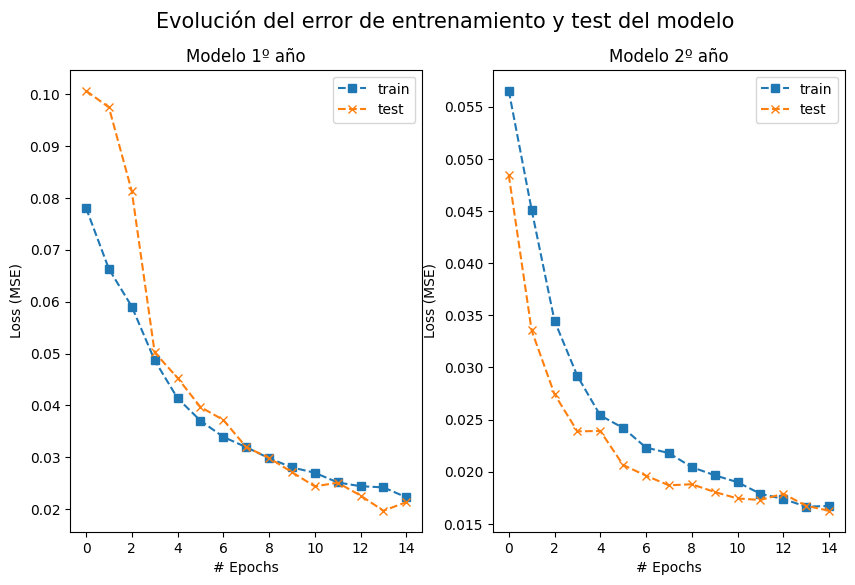

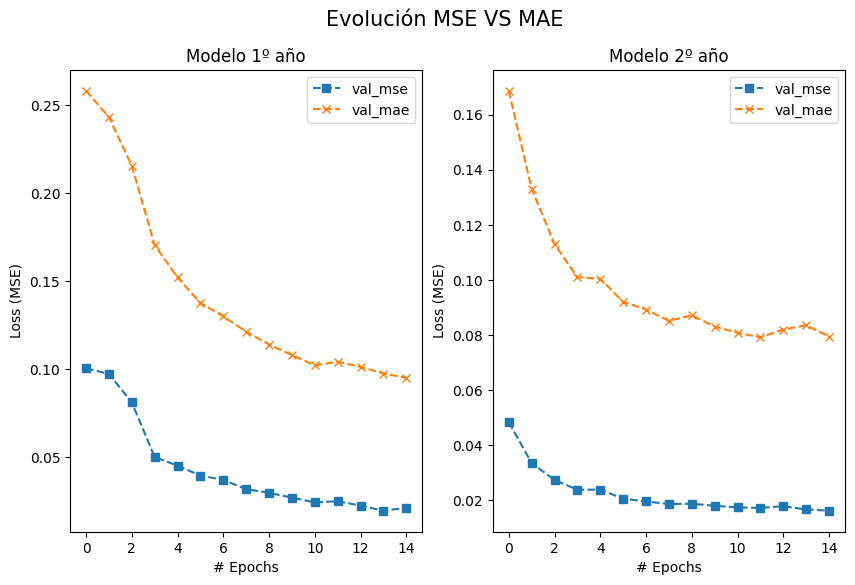

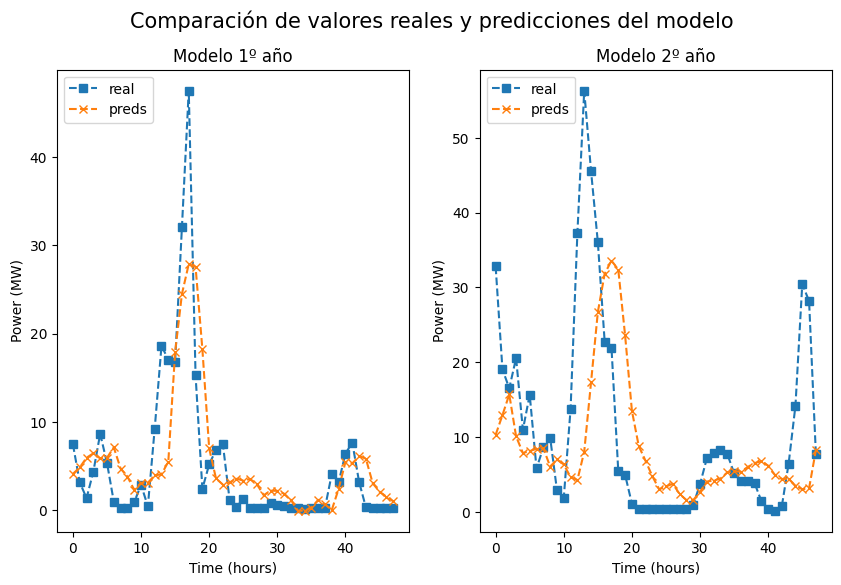

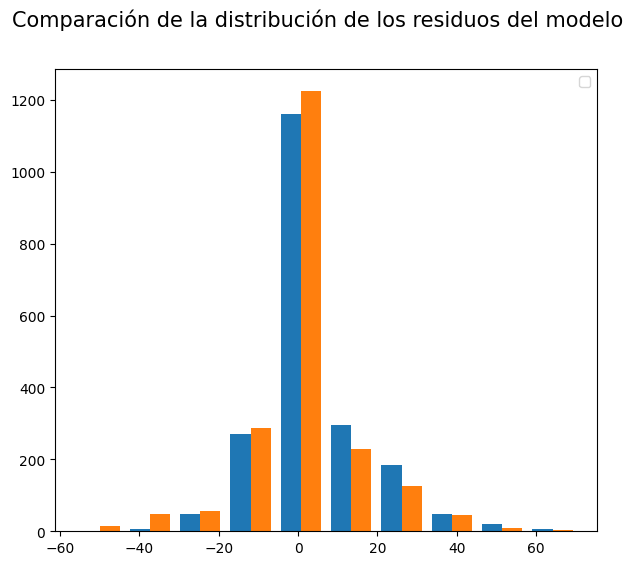

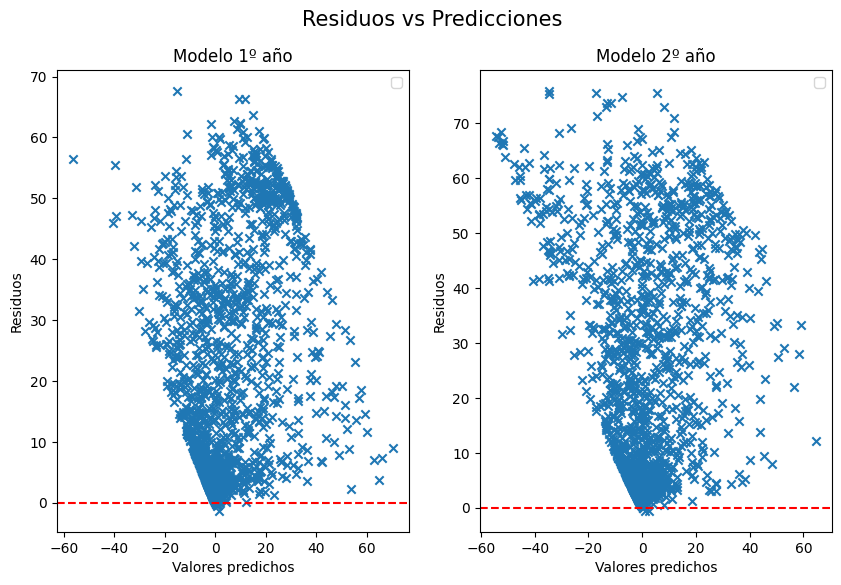

Config [7, 24, 32, 2, 30, 30, 150, 0.2]
                  RMSE       MAE        R2
Iteración 1  12.620650  8.173004  0.759354
Iteración 2  13.223784  8.173521  0.715057
cnn-lstm: 12.922 RMSE (+/- 0.302)
cnn-lstm: 8.173 MAE (+/- 0.000)
cnn-lstm: 0.737 R2 (+/- 0.022)


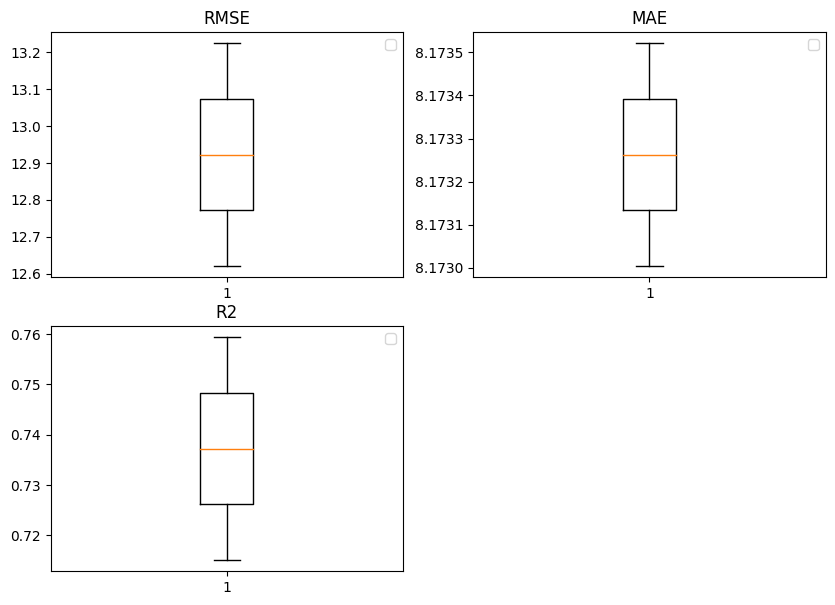

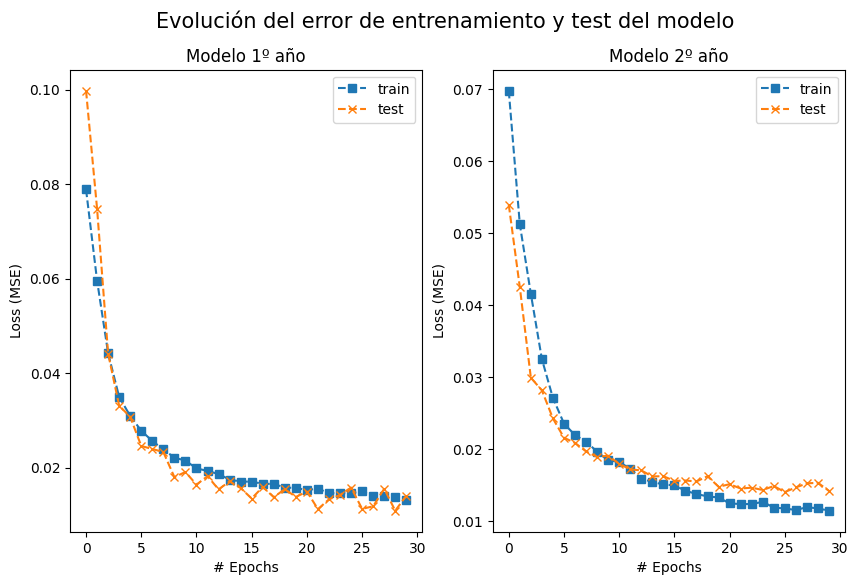

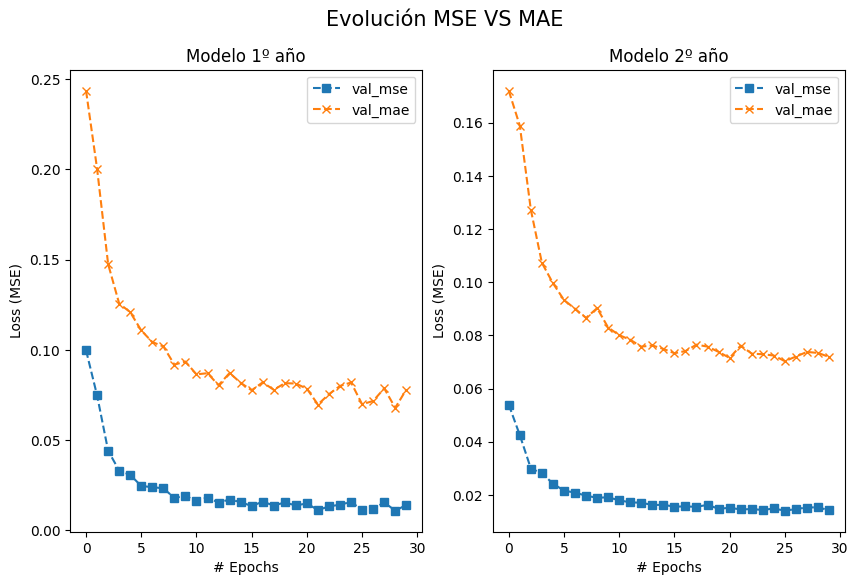

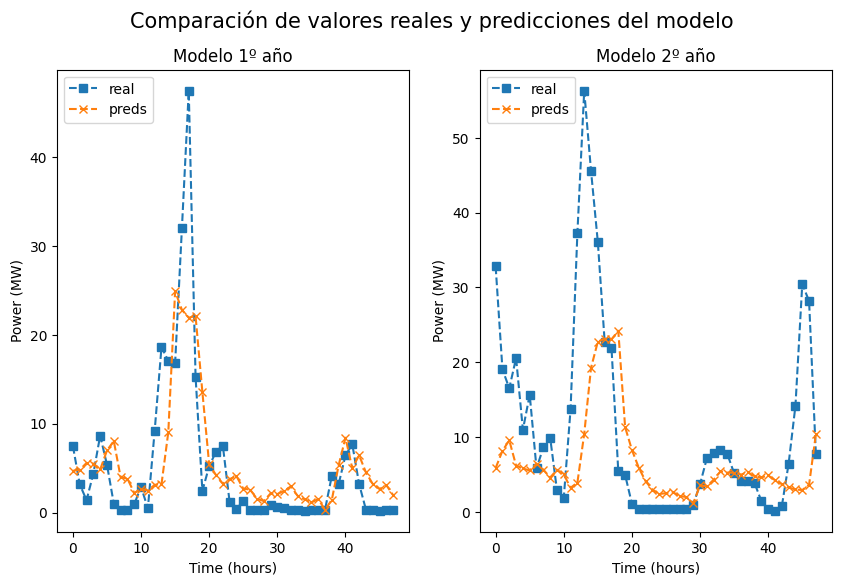

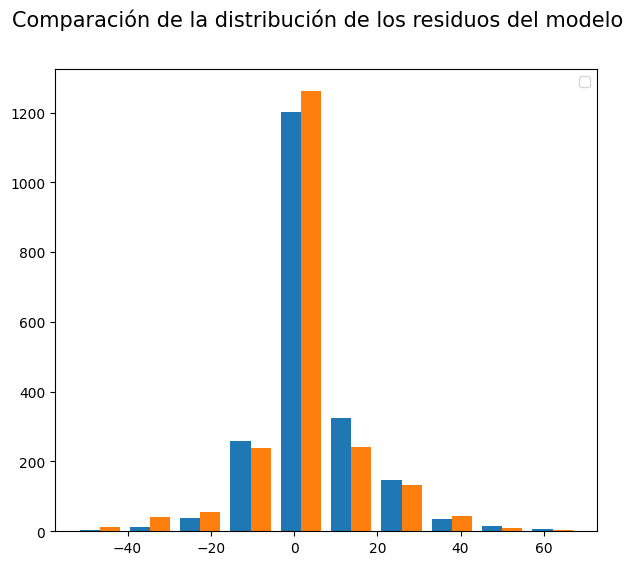

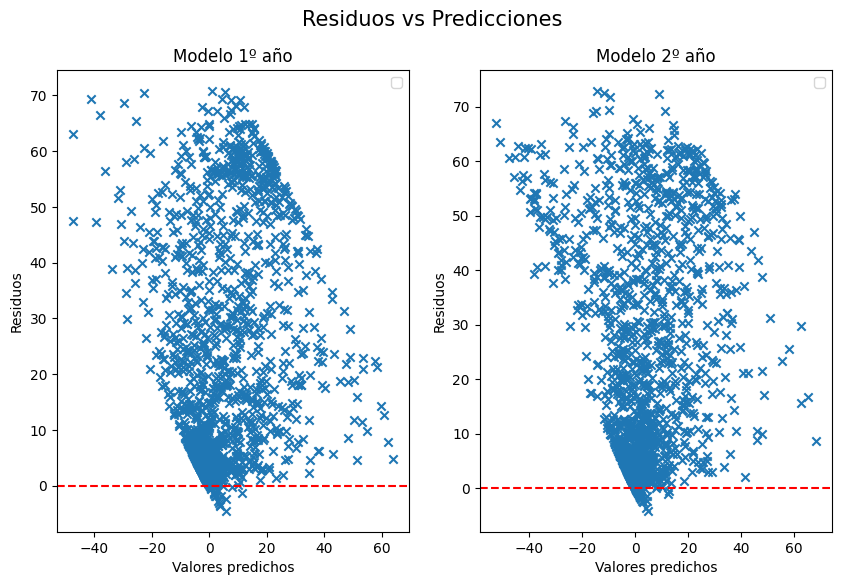

In [ ]:
scores = {config_1: (results_1, results_2) for (config_1, results_1), (config_2, results_2) in zip(scores_1, scores_2) if config_1 == config_2}
summarize_scores('cnn-lstm', scores)